In [1]:

import re
from dotenv import load_dotenv
load_dotenv()
from datasets import load_dataset
import numpy as np
import pandas as pd
import os
import torch
import re
from tqdm import tqdm


In [2]:
# scp -r loriss21cs@slurm01.vda.univie.ac.at:/srv/home/users/loriss21cs/babylm/mean_influence mean_influence

In [3]:
# input = "./mean_influence_divided_by_len_test/OLMo-2-1124-7B-SFT"
# for dir in tqdm(list(os.listdir(input))):
#     dataset_name = None
#     split = None
#     print(dir)
#     l = dir.split("]_")[-1]
  
#     if "train" in l:
#         l = l.split("_train[")
#         dataset_name = "anasedova/"+l[0]
#         split = "train["+l[1]
#     else:
#         l = l.split("_test[")
#         dataset_name = "anasedova/"+l[0]
#         split = "test["+l[1]

    
#     d = load_dataset(dataset_name, split=split)
#     print(dir, dataset_name, split, len(d))
#     path_in = os.path.join(input, dir, "main")
#     path_out = os.path.join("./mean_influence/OLMo-2-1124-7B-SFT", dir, "main")
#     os.makedirs(os.path.dirname(path_out))
#     torch.save(torch.load(path_in,weights_only=True,map_location="cpu") * len(d), path_out)

In [4]:
import numpy as np


In [5]:
import os

directory = "./mean_influence/OLMo-2-1124-7B-SFT/"


empty_subfolders = [
    os.path.join(root, d) for root, dirs, files in os.walk(directory) for d in dirs
    if not os.listdir(os.path.join(root, d)) 
]

for folder in empty_subfolders:
    if "dev" not in folder:
        print("rmdir",folder)


In [6]:
os.listdir(directory)

['tulu-3-sft-olmo-2-mixture_train[0%\uf03a1%]_olmes_tulu_3_unseen_test[0%\uf03a100%]',
 'tulu-3-sft-olmo-2-mixture_train[0%\uf03a1%]_tulu-3-sft-mixture_train[0%\uf03a100%]',
 'tulu-3-sft-olmo-2-mixture_train[0%\uf03a1%]_tulu_3_factual_errors_train[0%\uf03a100%]',
 'tulu-3-sft-olmo-2-mixture_train[0%\uf03a1%]_tulu_3_formatting_errors_train[0%\uf03a100%]',
 'tulu-3-sft-olmo-2-mixture_train[0%\uf03a1%]_tulu_3_incorrect_output_errors_train[0%\uf03a100%]',
 'tulu-3-sft-olmo-2-mixture_train[0%\uf03a1%]_tulu_3_model_modality_mismatch_errors_train[0%\uf03a100%]',
 'tulu-3-sft-olmo-2-mixture_train[0%\uf03a1%]_tulu_3_no_errors_train[0%\uf03a100%]',
 'tulu-3-sft-olmo-2-mixture_train[0%\uf03a1%]_tulu_3_underspecified_input_errors_train[0%\uf03a100%]',
 'tulu-3-sft-olmo-2-mixture_train[1%\uf03a2%]_olmes_tulu_3_unseen_test[0%\uf03a100%]',
 'tulu-3-sft-olmo-2-mixture_train[1%\uf03a2%]_tulu-3-sft-mixture_train[0%\uf03a100%]',
 'tulu-3-sft-olmo-2-mixture_train[1%\uf03a2%]_tulu_3_factual_errors_train[0%

In [7]:
directory = "./mean_influence/OLMo-2-1124-7B-SFT/"
prefix = "tulu-3-sft-olmo-2-mixture_train[26%\uf03a27%]_"
test_sets = [("anasedova/"+"_".join(dir.replace(prefix,"").split("_")[0:-1]), dir.replace(prefix,"").split("_")[-1]) for dir in  os.listdir(directory) if prefix in dir]

test_sets.append(("anasedova/olmes_tulu_3_unseen", "test[0%\uf03a100%]"))

In [20]:
import datasets 
schema = datasets.load_from_disk("./verb_confidence_exp_t/retrieved_documents/nq_llama8b-sft_test").features

folder = "./verb_confidence_exp_t/retrieved_documents"
candidate_schema = None 
for candidate_dataset in os.listdir(folder):
    candidate_schema = datasets.load_from_disk(os.path.join(folder,candidate_dataset))

    break

In [9]:
# schema = datasets.load_from_disk("./verb_confidence_exp_t/retrieved_documents/nq_llama8b-sft_test").features

In [ ]:
candidate_schema

In [10]:
# schema

In [11]:
# for query_col in [key for key in schema.keys() if "_query" in key]:
#     schema[query_col] = schema["response_query"]

In [12]:
# dataset = datasets.load_from_disk("./verb_confidence_exp_t/retrieved_documents/nq_llama8b-sft_test")
# dataset = dataset.map(features.encode_example, features=features)

In [13]:
# dataset.data.schema

In [14]:
# features

In [15]:
# set(error).difference(fine)

In [16]:
# set(fine).difference(error)

In [17]:
# del test_sets[test_sets.index(('anasedova/tulu_3_no_errors', 'train[0%\uf03a100%]'))]
# del test_sets[test_sets.index(('anasedova/tulu-3-sft-mixture', 'train[0%\uf03a100%]'))]

In [18]:
# test_sets = [t for t in test_sets if "_tulu_3_formatting_errors_train" not in t]

In [32]:
from datasets import Dataset


checkpoint = "main"

df_all_errors = load_dataset("anasedova/tulu_3_all_errors_upd", split="train").select_columns(["ordinal_id", "noise_type"])
dff = load_dataset("allenai/tulu-3-sft-olmo-2-mixture", split="train[0%:100%]").select_columns(["id"]).to_pandas()
def load_data(train_dataset_name, dataset_train_split, test_dataset_name, dataset_test_split, model_name, influence_output_dir="./mean_influence", checkpoint="main"):

    assert train_dataset_name == "allenai/tulu-3-sft-olmo-2-mixture", "move loading inside function"
    influence_output_dir = os.path.join(influence_output_dir, os.path.basename(model_name))
 
   # dataset = load_dataset(train_dataset_name, split=dataset_train_split).select_columns(["id"])
    # len_dataset_test = len(load_dataset(test_dataset_name, split=dataset_test_split))
    
    pattern = re.compile(rf"{re.escape(os.path.basename(train_dataset_name))}_.*_{re.escape(os.path.basename(test_dataset_name))}")

    train_splits = [dataset_train_split.split("[")[0] + f"[{i}%\uf03a{i + 100 // 100}%]" for i in range(0, 100, 100 // 100)]

    files = [file for file in os.listdir(influence_output_dir) if pattern.search(file)]

    # verify all files are ready
    for train_split in train_splits:
        if not(any([os.path.basename(train_dataset_name) + "_" + train_split in file for file in files])):
            print(f"python process_gradients.py {model_name} {train_dataset_name} {0} --dataset_train_split={train_split} --dataset_test={test_dataset_name} --dataset_test_split={dataset_test_split} --mode=mean  --batch_size=10")
            raise FileNotFoundError
        
        

    for result_superbatch in files:
        try:
            torch.load(os.path.join(influence_output_dir,result_superbatch, checkpoint),weights_only=True,map_location="cpu")
        except:
            print(result_superbatch)
    

    idx, results_superbatches = zip(*sorted([(int(re.search(r"\[(\d*)\%", result_superbatch).group(1)), torch.load(os.path.join(influence_output_dir,result_superbatch, checkpoint),weights_only=True,map_location="cpu").numpy().flatten()) for result_superbatch in files], key=lambda x: x[0]))



    influence_scores = np.concat(results_superbatches)
    # influence_scores = influence_scores * len_dataset_test # TODO hotfix

    df = pd.DataFrame(influence_scores)
    df.columns = ["influence"]

    df = df.reindex(sorted(df.columns, reverse=False), axis=1)

    assert len(dff) == len(df)



    df[dff.columns] = dff  



    
    # TODO hotfix as old influence datasets lack noise_type col
    ds = Dataset.from_pandas(df)
    if train_dataset_name == "allenai/tulu-3-sft-olmo-2-mixture":
        # assuming "ds" is 1:1 allenai/tulu-3-sft-olmo-2-mixture  
        a = ["no"] * len(dff)
        for row in df_all_errors:
            a[row["ordinal_id"]] = row["noise_type"]
        ds = ds.add_column("noise_type", a)
    return ds

dfs = []
for i, (test_dataset_name, test_split) in enumerate(test_sets):
    print(i)
    ds = load_data(
        "allenai/tulu-3-sft-olmo-2-mixture", 
        "train[0%:100%]",
        test_dataset_name,
        test_split,
        "allenai/OLMo-2-1124-7B-SFT",
        )
    df = ds.to_pandas()
    df["test_dataset"] = test_dataset_name
    dfs.append(df)






0
1
2
3
4
5
6
7
8


In [33]:
df = pd.concat(dfs)

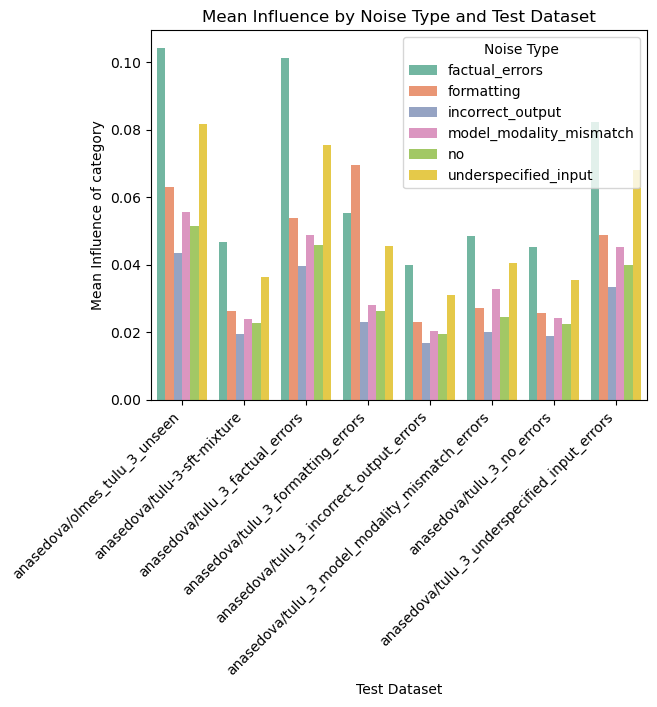

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

grouped = df.groupby(["test_dataset", "noise_type"])["influence"].mean().reset_index()


sns.barplot(data=grouped, x='test_dataset', y='influence', hue='noise_type', palette="Set2")

plt.title("Mean Influence by Noise Type and Test Dataset")
plt.xlabel("Test Dataset")
plt.ylabel("Mean Influence of category")
plt.legend(title='Noise Type')
plt.xticks(rotation=45, ha='right')
plt.show()


In [ ]:
df[df["test_dataset"] == "anasedova/tulu_3_incorrect_output_errors"].describe()

,influence
count,939344.000000
mean,0.018866
std,0.024057
min,-0.145508
25%,0.005219
50%,0.010681
75%,0.021484
max,1.726562


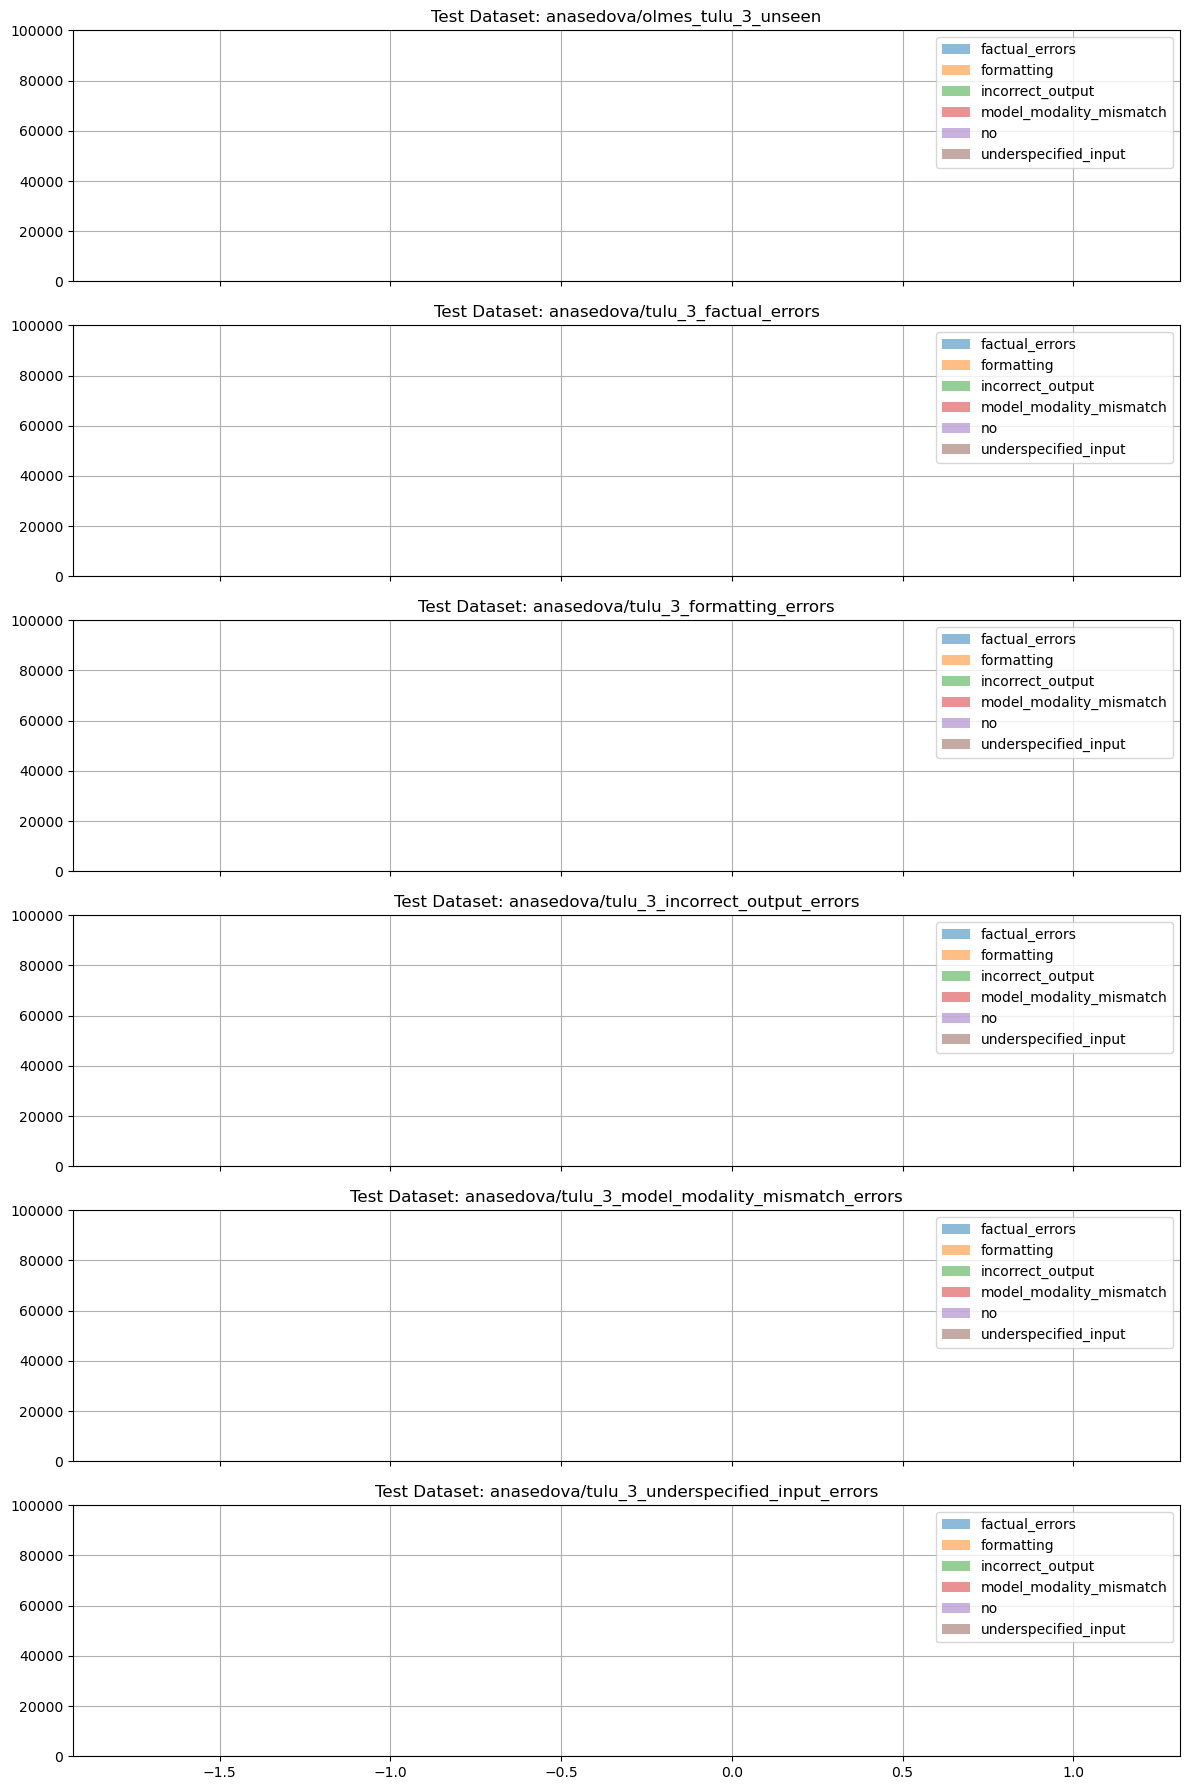

In [ ]:
import matplotlib.pyplot as plt


unique_datasets = df["test_dataset"].unique()
num_datasets = len(unique_datasets)

fig, axes = plt.subplots(num_datasets, 1, figsize=(12, 3 * num_datasets), sharex=True)


for ax, (name, df_) in zip(axes, df.groupby(by="test_dataset")):
    df_.groupby(by="noise_type")["influence"].hist(ax=ax, legend=True, bins=500, density=True, alpha=0.5)
    ax.set_title(f"Test Dataset: {name}")
    ax.set_xlim(df["influence"].min(), df["influence"].max() * 0.3)
    ax.set_ylim(0,100000)

plt.tight_layout()
plt.show()


In [ ]:
afdyfrefdf.groupby(by="noise_type")["influence"].count()

NameError: name 'afdyfrefdf' is not defined

In [ ]:
df.groupby(by="noise_type")["influence"].describe()

In [ ]:
# ANOVA
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = smf.ols("influence ~ C(noise_type)", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd


tukey_results = pairwise_tukeyhsd(df["influence"], df["noise_type"], alpha=0.05)

print(tukey_results)


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

for name, df_ in df.groupby(by="test_dataset"):
    tukey_results = pairwise_tukeyhsd(df_["influence"], df_["noise_type"], alpha=0.05)
    print(name)
    print(tukey_results)


In [ ]:
df

In [ ]:
import itertools
import pandas as pd
from scipy.stats import ks_2samp


ks_results = []
for a, b in itertools.combinations( df["group"].unique(), 2):
    group1 = df[df["group"] == a]["influence"]
    group2 = df[df["group"] == b]["influence"]
    # print(len(group1), len(group2))
    ks_stat, p_value = ks_2samp(group1, group2)
    ks_results.append([a, b, ks_stat, p_value, p_value < 0.05])
pd.DataFrame(ks_results, columns=["group1", "group2", "KS-stat", "p-adj", "reject"])



In [ ]:
You can now access the mean influence of any noise_category on any of the datasets, e.g.,

- "the mean influence underspecified_input[123] has on examples in olmes"
- "the mean influence examples from underspecified_input has on examples in olmes" `df.groupby("noise_type").mean()`
- "the mean influence of examples in tulu if prompted with examples from underspecified_input"
- etc

What combinations do you want (there are 7*7)?
Should I just provide you one big dataframe with "influence", "example a", "noise type a", "example b", "noise type b" (noise_type is "no" if not present in datasets or from olmes)?
So that you can compare e.g. group means?